<a id="contents_tabel"></a>    
<div style="border-radius:40px; padding: 25px; font-size:115%; text-align:left">


<span style="color:#dc2f02; font-size: 200%; font-weight: bold;">Table of Contents</span>
    
* [Step 1 | Import Libraries](#import)
* [Step 2 | Read Dataset](#read)
* [Step 3 | Dataset Overview](#overview)
    - [Step 3.1 | Dataset Basic Information](#basic)
    - [Step 3.2 | Summary Statistics for Numerical Variables](#num_statistics)
    - [Step 3.3 | Summary Statistics for Categorical Variables](#cat_statistics)
* [Step 4 | EDA](#eda)
    - [Step 4.1 | Univariate Analysis](#univariate)
        - [Step 4.1.1 | Numerical Variables Univariate Analysis](#num_uni)
        - [Step 4.1.2 | Categorical Variables Univariate Analysis](#cat_uni)
    - [Step 4.2 | Bivariate Analysis](#bivariate)
        - [Step 4.2.1 | Numerical Features vs Target](#num_target)
        - [Step 4.2.2 | Categorical Features vs Target](#cat_target)
* [Step 5 | Data Preprocessing](#preprocessing)
* [Step 6 | Model Training](#training)


In [1]:
import os

In [2]:
%pwd

'c:\\development\\Machine-Learning\\end-to-end-ml-project\\research'

In [3]:
os.chdir('../')

In [4]:
%pwd

'c:\\development\\Machine-Learning\\end-to-end-ml-project'

In [128]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class DataValidationConfig:
    root_dir: Path
    STATUS_FILE: str
    unzip_dir : Path
    all_schema: Path

In [100]:
from ml_project.constants import *
from ml_project.utils.common import read_yaml , create_directories

In [125]:
# type: ignore
class ConfigurationManager:
    def __init__(
        self,
        config_filepath: CONFIG_FILE_PATH, 
        params_filepath: PARAMS_FILE_PATH,
        schema_filepath: SCHEMA_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
        
    def get_data_validation_config(self)-> DataValidationConfig:
        config = self.config.data_validation
        schema = self.schema.COLUMNS
        
        create_directories([config.root_dir])
        
        return DataValidationConfig(
            root_dir = config.root_dir,
            STATUS_FILE= config.STATUS_FILE,
            unzip_dir=config.unzip_dir,
            all_schema=schema
        )

In [105]:
import os
from ml_project import logger

import pandas as pd

In [121]:
class DataValidation:
    
    def __init__(self, config: DataValidationConfig):
        self.config = config
    def validate_all_columns(self)-> bool:
        try:
            validation_status = None

            data = pd.read_csv(self.config.unzip_dir)
            all_cols = list(data.columns)

            all_schema = self.config.all_schema.keys()

            
            for col in all_cols:
                if col not in all_schema:
                    validation_status = False
                    with open(self.config.STATUS_FILE, 'w') as f:
                        f.write(f"Validation status: {validation_status}")
                else:
                    validation_status = True
                    with open(self.config.STATUS_FILE, 'w') as f:
                        f.write(f"Validation status: {validation_status}")

            return validation_status
        
        except Exception as e:
            raise e    

In [129]:
try:
    config = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH)
    data_validation_config = config.get_data_validation_config()
    data_validation = DataValidation(data_validation_config)
    data_validation.validate_all_columns()
except Exception as e:
    raise e    

[2024-02-24 15:44:58,517: INFO: common:  yaml file: config\config.yaml loaded successfully]
[2024-02-24 15:44:58,518: INFO: common:  yaml file: params.yaml loaded successfully]
[2024-02-24 15:44:58,520: INFO: common:  yaml file: schema.yaml loaded successfully]
[2024-02-24 15:44:58,520: INFO: common:  created directory at: artifacts]
[2024-02-24 15:44:58,520: INFO: common:  created directory at: artifacts/data_validation]


<a id="import"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 1 | Import Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [5]:
import pandas as pd
import numpy as np

# to visualize the dataset

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

<a id="read"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 2 | Read Dataset</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [6]:
# Load the dataset
df = pd.read_csv('artifacts/data_ingestion/bank-full.csv', delimiter=';')

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [9]:
for i in range(0, len(df.columns)):
    print(df.columns[i]+":", df[df.columns[i]].dtype)

age: int64
job: object
marital: object
education: object
default: object
balance: int64
housing: object
loan: object
contact: object
day: int64
month: object
duration: int64
campaign: int64
pdays: int64
previous: int64
poutcome: object
y: object


<a id="overview"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 3 | Dataset Overview</p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="basic"></a>
# <b><span style='color:#ff826e'>Step 3.1 |</span><span style='color:red'> Dataset Basic Information</span></b>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


<h2 align="left"><font color=red>Inferences:</font></h2>

* __Number of Entries__: The dataset consists of __45211 entries__, ranging from index 0 to 45210.
    
    
* __Columns__: There are __17 columns__ in the dataset. The columns are as follows:
    - __age__: The age of the individual.
    - __job__: The job of the individual.
    - __marital__: The marital status of the individual.
    - __education__: The education level of the individual.
    - __default__: Whether the individual has credit in default.
    - __balance__: The individual's average yearly balance in euros.
    - __housing__: Whether the individual has a housing loan.
    - __loan__: Whether the individual has a personal loan.
    - __contact__: The type of communication used to contact the individual.
    - __day__: The day of the month when the individual was last contacted.
    - __month__: The month when the individual was last contacted.
    - __duration__: The duration of the last contact with the individual.
    - __campaign__: The number of contacts performed during this campaign for the individual.
    - __pdays__: The number of days that passed by after the individual was last contacted from a previous campaign.
    - __previous__: The number of contacts performed before this campaign for the individual.
    - __poutcome__: The outcome of the previous marketing campaign.
    - __y__: Whether the individual has subscribed to a term deposit.
    
    
* __Data Types__:
    - __Categorical__: The dataset contains 10 categorical columns.
    - __Numerical__: The dataset contains 7 numerical columns.
    
    
* __Missing Values__: There don't appear to be any missing values in the dataset as each column has 45211 non-null entries.

In [11]:
# Define the continuous features

continuous_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

<a id="num_statistics"></a>
# <b><span style='color:#ff826e'>Step 3.2 |</span><span style='color:red'> Summary Statistics for Numerical Variables</span></b>

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


<a id="eda"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 4| EDA </p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="univariate"></a>
# <b><span style='color:#ff826e'>Step 4.1 |</span><span style='color:red'> Univariate Analysis</span></b>

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

We undertake univariate analysis on the dataset's features, based on their datatype:

* For __continuous data__: We employ histograms to gain insight into the distribution of each feature. This allows us to understand the central tendency, spread, and shape of the dataset's distribution.

    
* For __categorical data__: Bar plots are utilized to visualize the frequency of each category. This provides a clear representation of the prominence of each category within the respective feature.

By employing these visualization techniques, we're better positioned to understand the individual characteristics of each feature in the dataset.

<a id="num_uni"></a>
### <b><span style='color:#ff826e'>Step 4.1.1 |</span><span style='color:red'> Numerical Variables Univariate Analysis</span></b>  

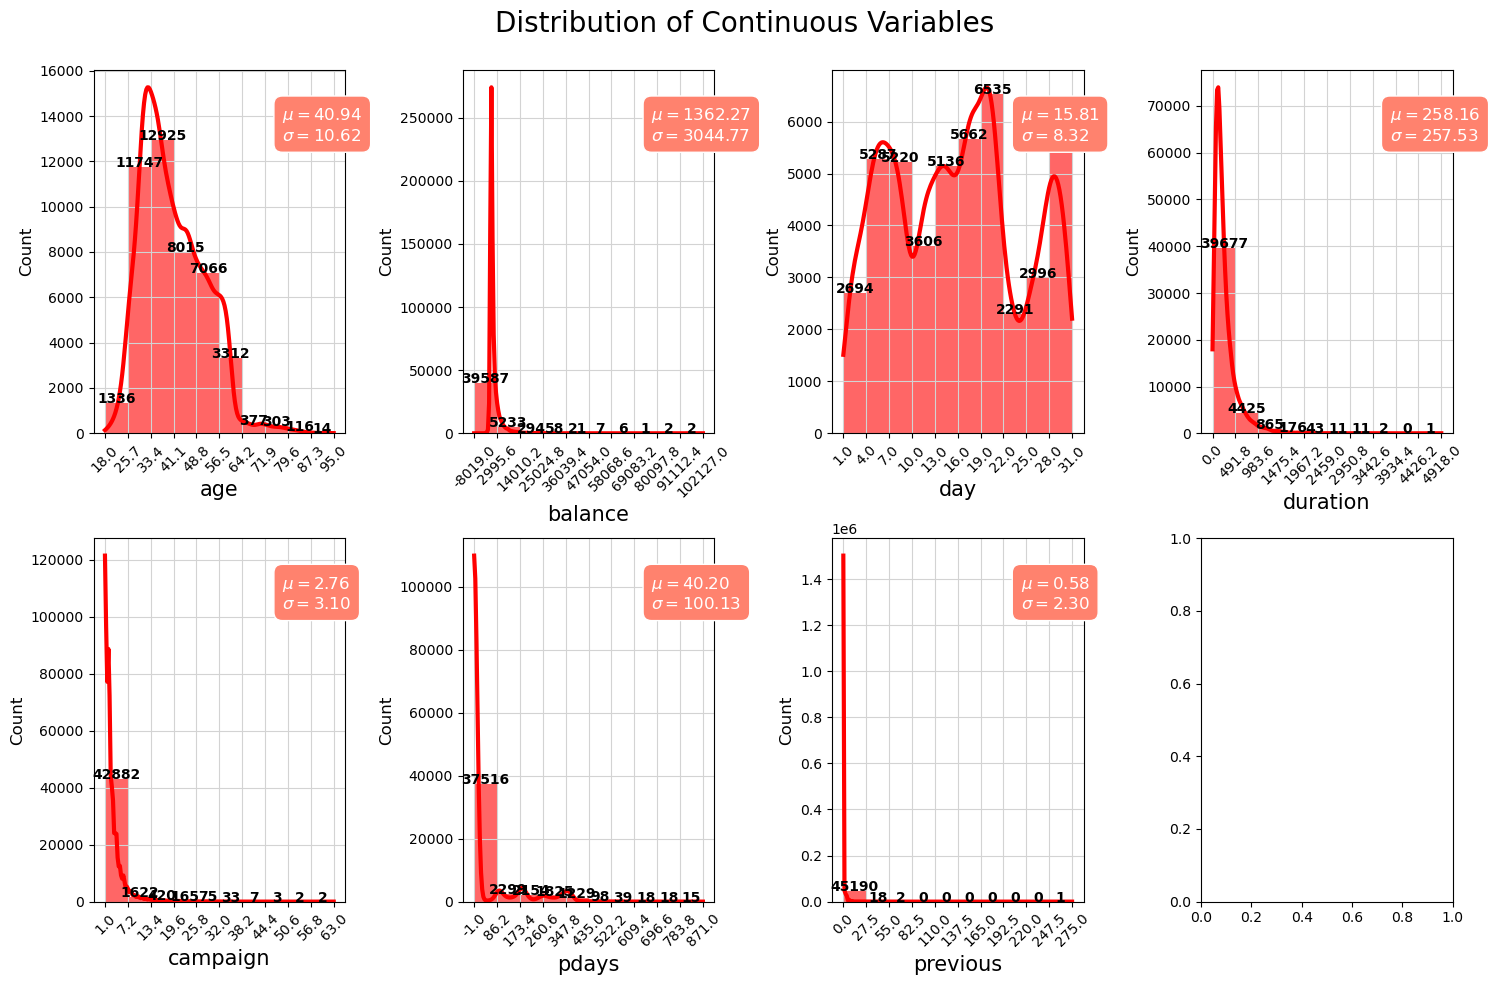

In [13]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 4
    y = i % 4
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))


plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

<a id="cat_uni"></a>
### <b><span style='color:#ff826e'>Step 4.1.2 |</span><span style='color:red'> Categorical Variables Univariate Analysis</span></b>  

In [14]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

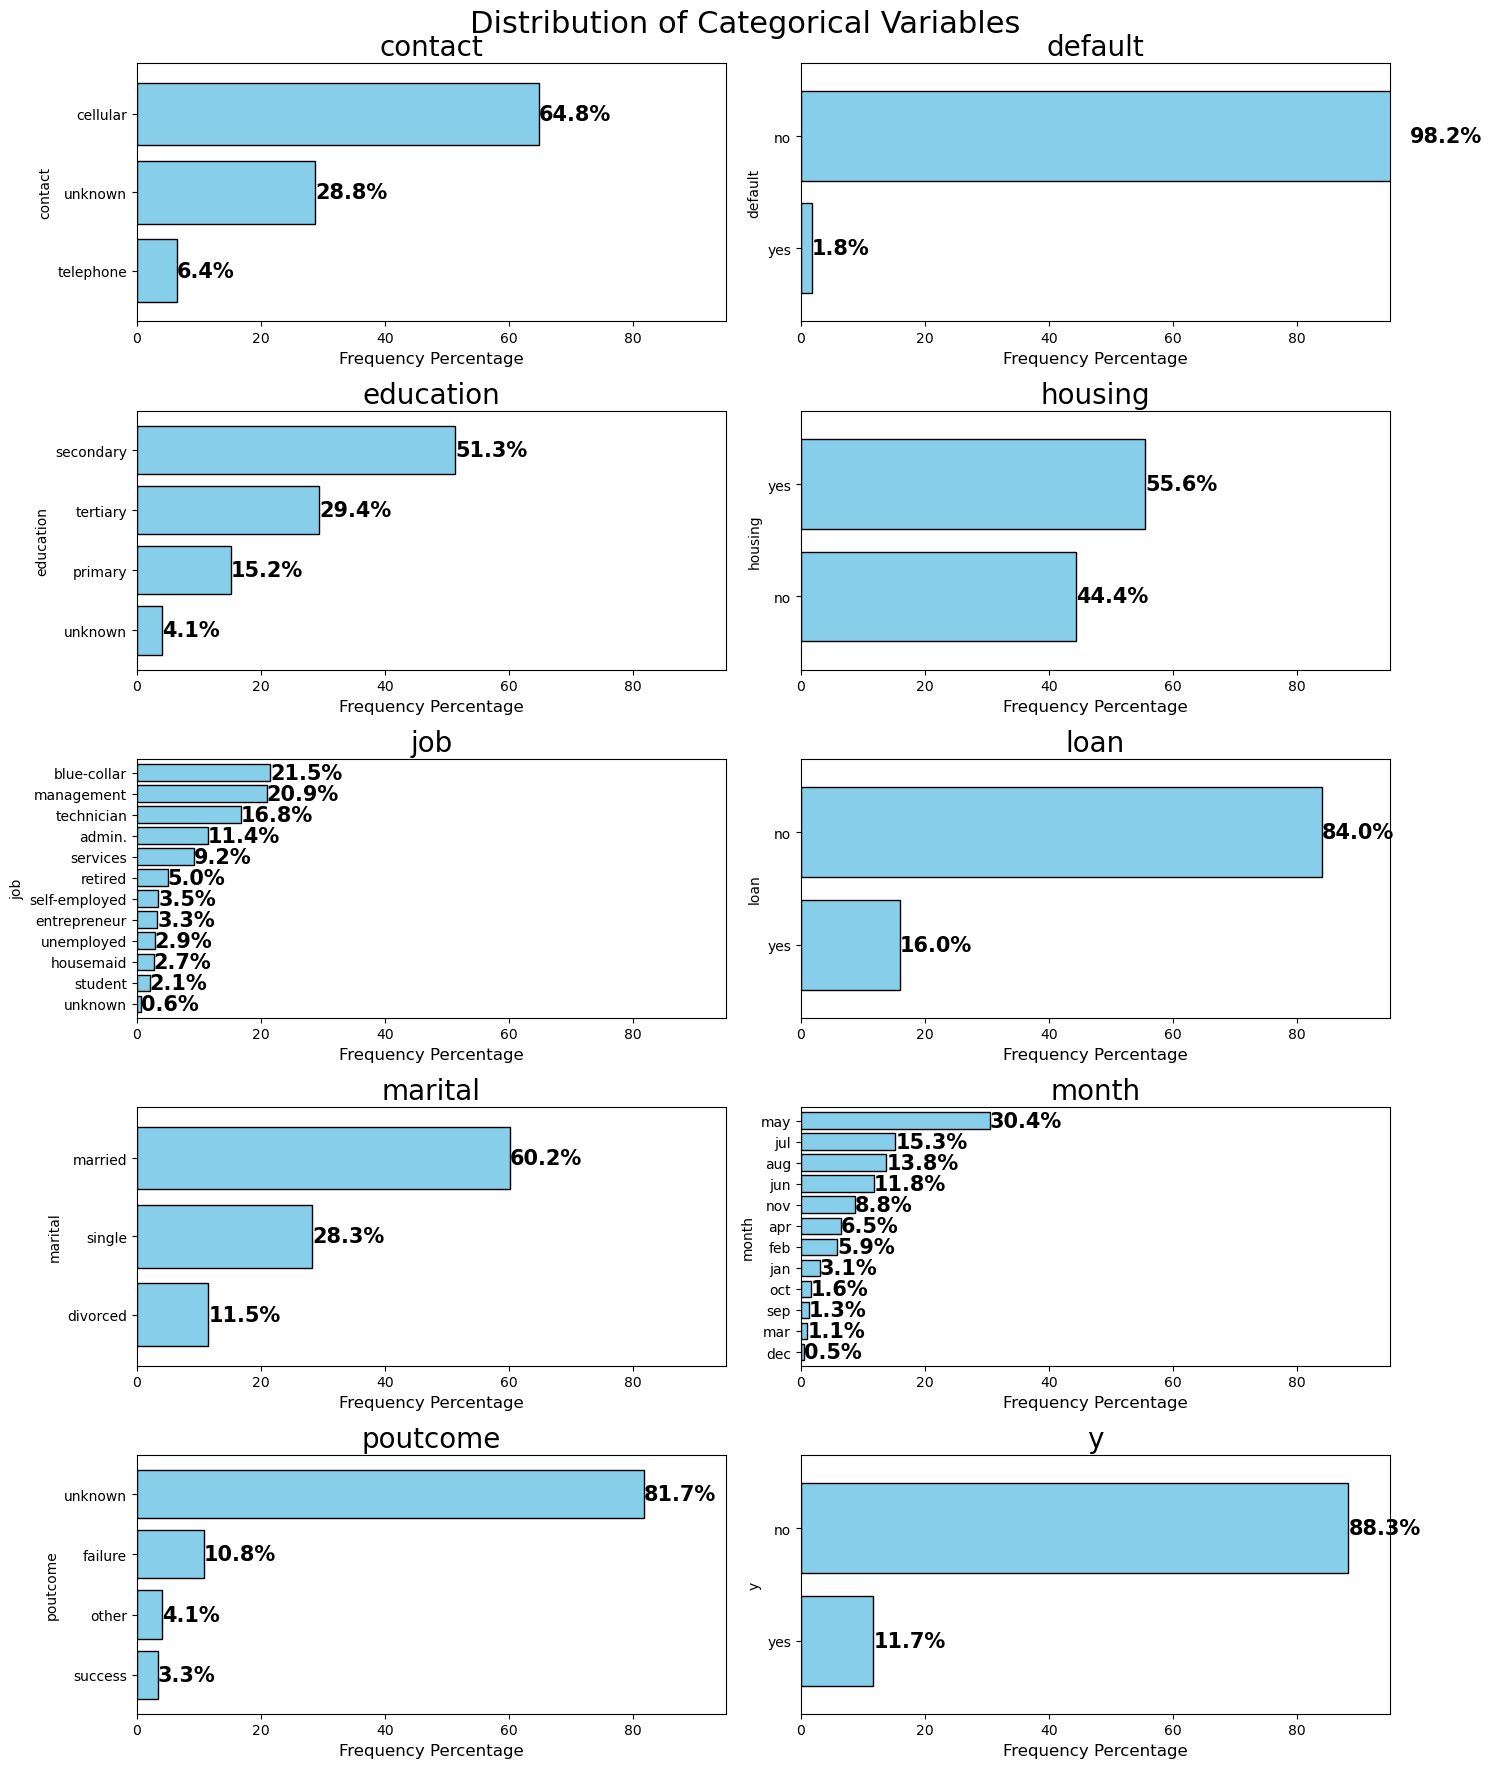

In [15]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='skyblue', edgecolor='black')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)


plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

<a id="bivariate"></a>
# <b><span style='color:#ff826e'>Step 4.2 |</span><span style='color:red'> Bivariate Analysis</span></b>

<a id="num_target"></a>
### <b><span style='color:#ff826e'>Step 4.2.1 |</span><span style='color:red'> Numerical Features vs Target</span></b>  

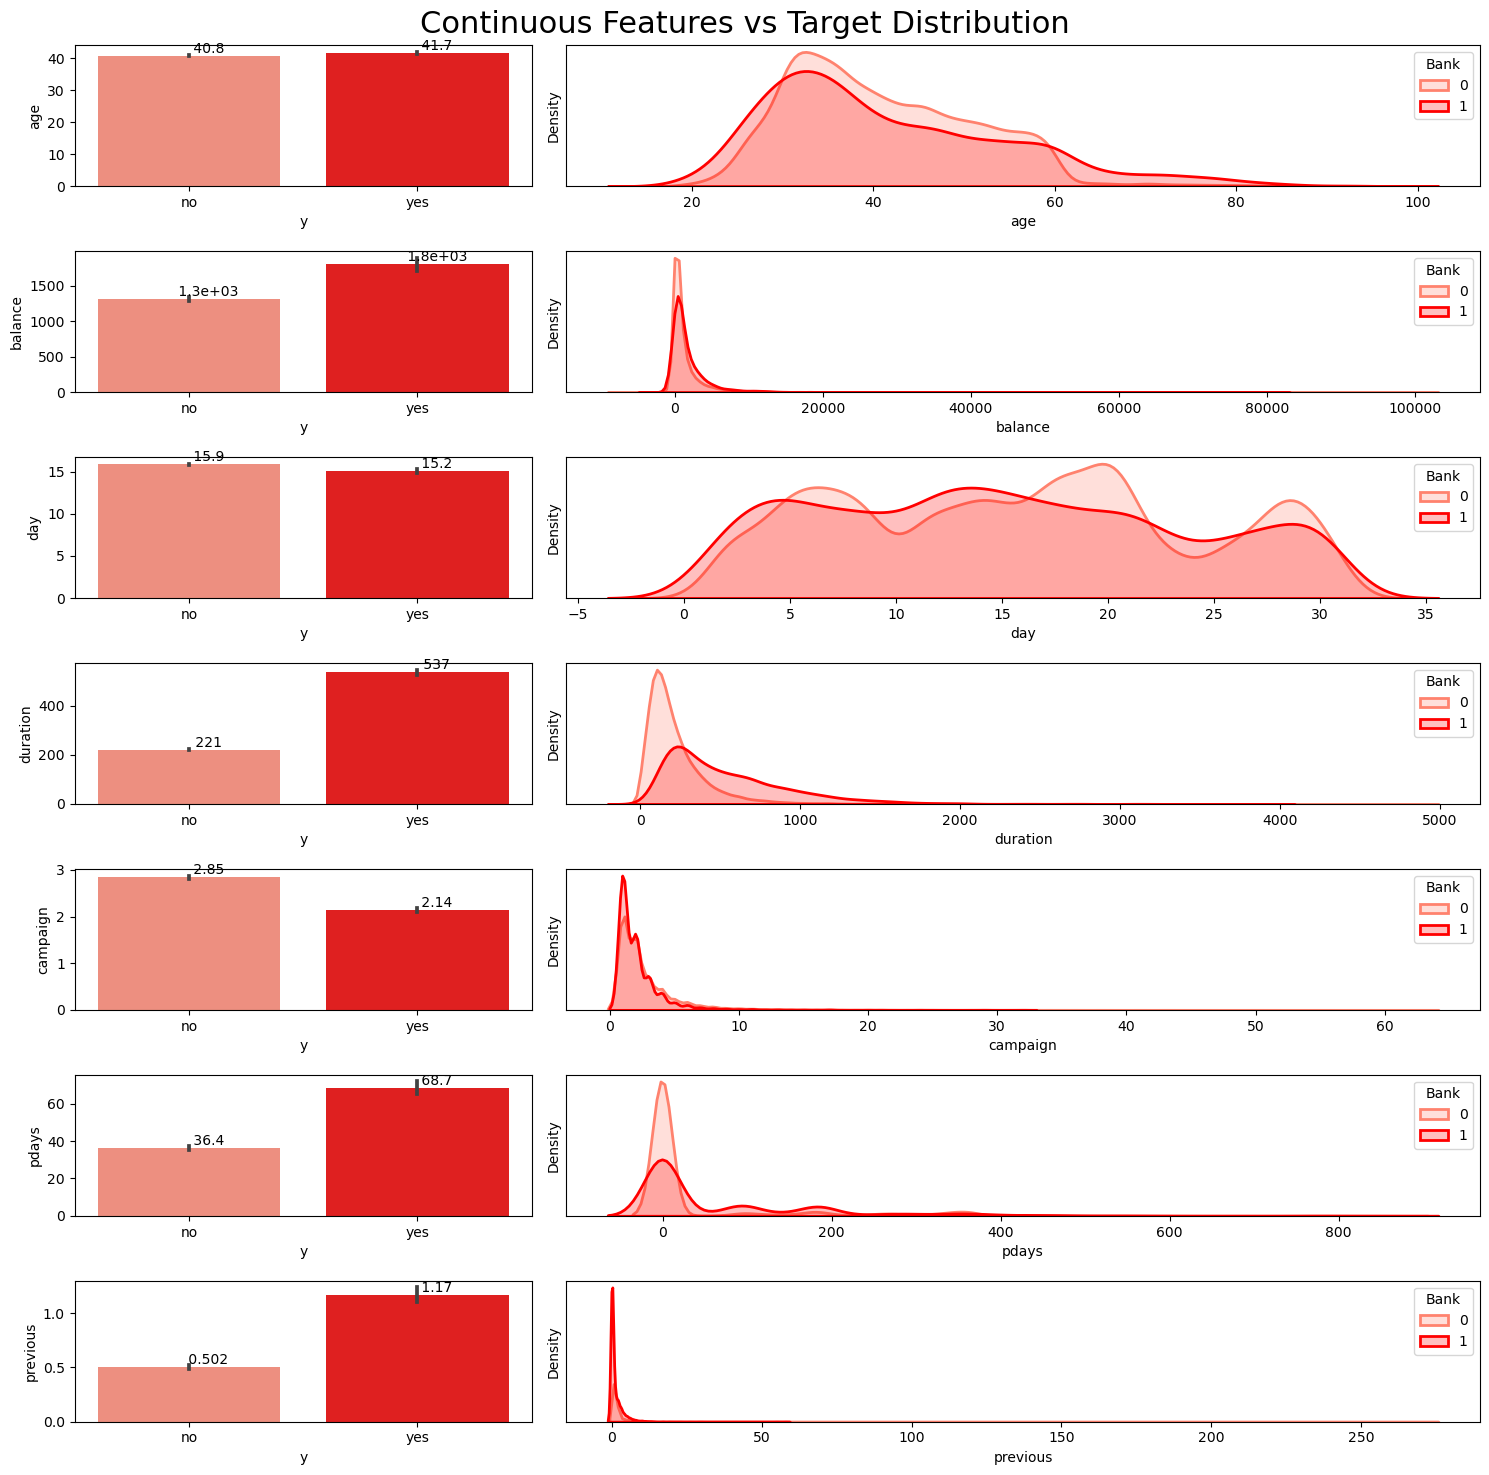

In [16]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="y", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["y"]=='no'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["y"]=='yes'], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Bank', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

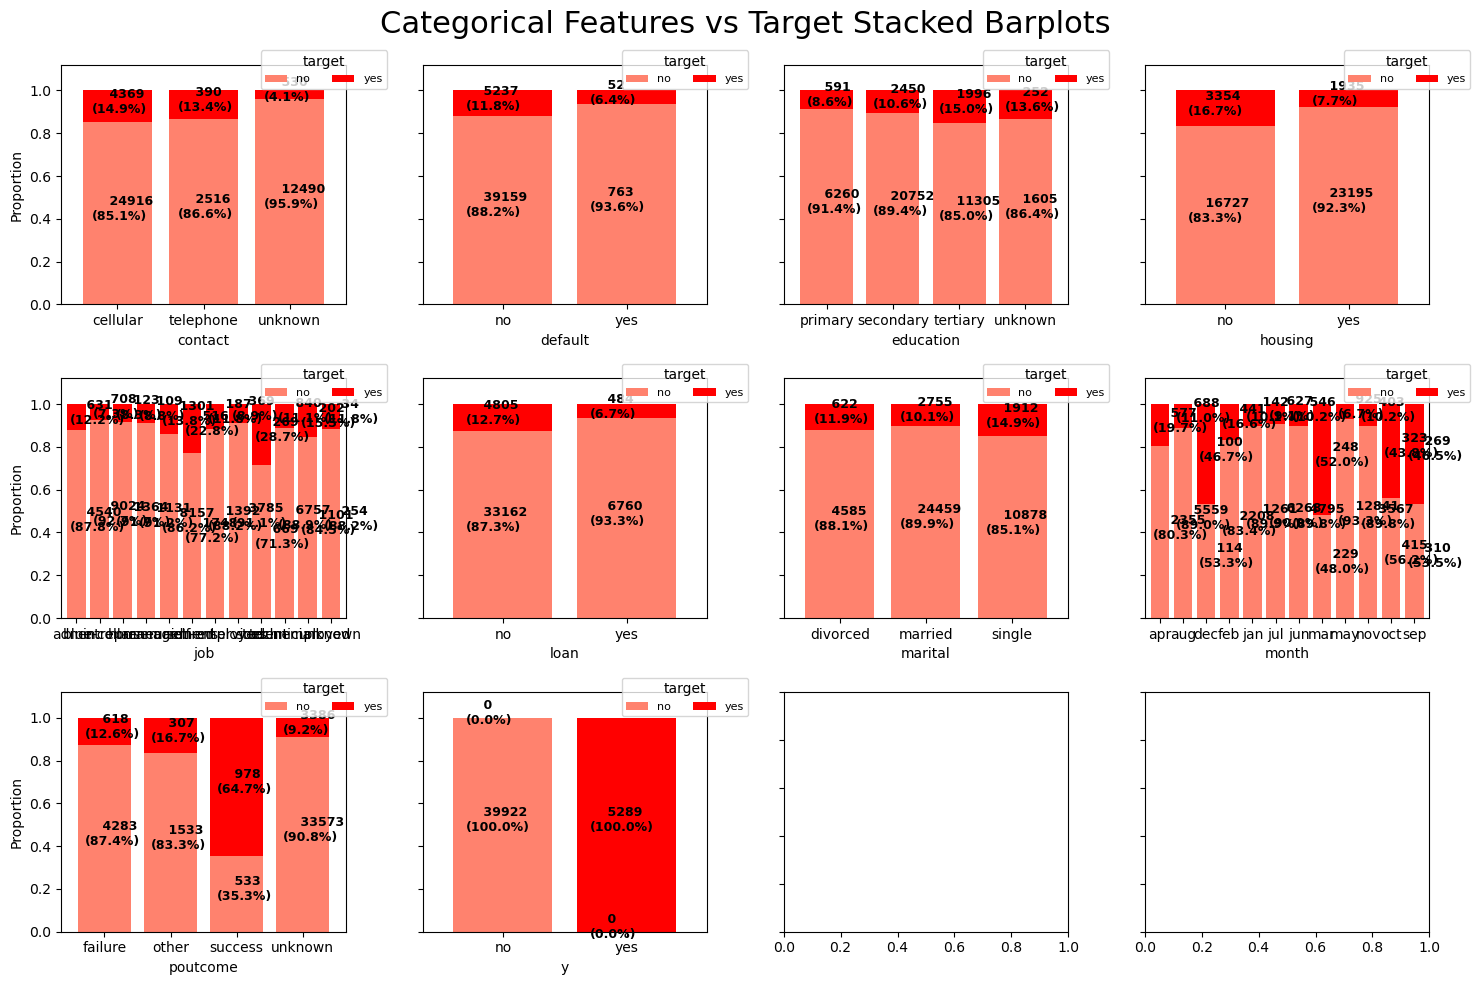

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['y'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['y'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

<a id="preprocessing"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 5 | Data Preprocessing</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [18]:
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

df.month = df.month.map(month_mapping)

df.day = df.day.astype(str).str.zfill(2)
df.month = df.month.astype(str).str.zfill(2)

df['date'] = df.day + '-' + df.month

df['date_month'] = pd.to_datetime('2024-' + df['date'], format='%Y-%d-%m', errors='coerce')\
                       .dt.strftime('%d-%m')

df.drop(['date', 'day', 'month'], axis=1, inplace=True)

In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_month
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,05-05
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,05-05
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,05-05
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,05-05
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,05-05


In [20]:
blanks = []
for age in df['age']:
    if 18 <= age <= 30:
        blanks.append('18-30')
    elif 31 <= age <= 40:
        blanks.append('31-40')
    elif 41 <= age <= 50:
        blanks.append('41-50')
    elif 51 <= age <= 60:
        blanks.append('51-60')
    elif 61 <= age <= 70:
        blanks.append('61-70')
    elif 71 <= age <= 80:
        blanks.append('71-80')
    elif 81 <= age <= 90:
        blanks.append('81-90')
    elif 91 <= age <= 95:
        blanks.append('91-95')
    else:
        blanks.append('Unknown')
        
df['age_group'] = blanks

In [21]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_month,age_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,05-05,51-60
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,05-05,41-50
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,05-05,31-40
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,05-05,41-50
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,05-05,31-40


In [22]:
df.drop(['age' ], axis=1, inplace=True)

In [23]:
categorical_features = df[[col for col in df.columns if df[col].dtype == 'object']]
continuous_features = df[[col for col in df.columns if df[col].dtype != 'object']]

In [24]:
categorical_features.nunique()

job            12
marital         3
education       4
default         2
housing         2
loan            2
contact         3
poutcome        4
y               2
date_month    318
age_group       8
dtype: int64

In [25]:
def binary_encoding(df, columns, positive_value):
    for col in columns:
        df[col] = df[col].apply(lambda x: 1 if x == positive_value else 0)
    return df

In [26]:
binary_columns = ['default', 'housing', 'loan', 'y']

df = binary_encoding(df, binary_columns, 'yes')

In [27]:
df.head()

,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_month,age_group
0,management,married,tertiary,0,2143,1,0,unknown,261,1,-1,0,unknown,0,05-05,51-60
1,technician,single,secondary,0,29,1,0,unknown,151,1,-1,0,unknown,0,05-05,41-50
2,entrepreneur,married,secondary,0,2,1,1,unknown,76,1,-1,0,unknown,0,05-05,31-40
3,blue-collar,married,unknown,0,1506,1,0,unknown,92,1,-1,0,unknown,0,05-05,41-50
4,unknown,single,unknown,0,1,0,0,unknown,198,1,-1,0,unknown,0,05-05,31-40


In [28]:
one_hot_columns = ['job', 'marital', 'education', 'contact', 'poutcome']
label_columns = ['age_group' , 'date_month']

In [29]:
df_copy = df.copy()

In [30]:
df.head()

,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_month,age_group
0,management,married,tertiary,0,2143,1,0,unknown,261,1,-1,0,unknown,0,05-05,51-60
1,technician,single,secondary,0,29,1,0,unknown,151,1,-1,0,unknown,0,05-05,41-50
2,entrepreneur,married,secondary,0,2,1,1,unknown,76,1,-1,0,unknown,0,05-05,31-40
3,blue-collar,married,unknown,0,1506,1,0,unknown,92,1,-1,0,unknown,0,05-05,41-50
4,unknown,single,unknown,0,1,0,0,unknown,198,1,-1,0,unknown,0,05-05,31-40


In [31]:
label_encoder = LabelEncoder()

df_copy = pd.get_dummies(df, columns=one_hot_columns, drop_first=True, dtype='int64')

for col in label_columns:
    df_copy[col] = label_encoder.fit_transform(df_copy[col])


In [32]:
df_copy.head()

,default,balance,housing,loan,duration,campaign,pdays,previous,y,date_month,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,2143,1,0,261,1,-1,0,0,40,...,1,0,0,1,0,0,1,0,0,1
1,0,29,1,0,151,1,-1,0,0,40,...,0,1,1,0,0,0,1,0,0,1
2,0,2,1,1,76,1,-1,0,0,40,...,1,0,1,0,0,0,1,0,0,1
3,0,1506,1,0,92,1,-1,0,0,40,...,1,0,0,0,1,0,1,0,0,1
4,0,1,0,0,198,1,-1,0,0,40,...,0,1,0,0,1,0,1,0,0,1


In [33]:
#scaling

scaler = StandardScaler()

df_copy[continuous_features.columns] = scaler.fit_transform(df_copy[continuous_features.columns])

In [34]:
df_copy.columns

Index(['default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'pdays', 'previous', 'y', 'date_month', 'age_group', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [35]:
X = df_copy.drop('y', axis=1)
y = df_copy['y']

from sklearn.feature_selection import mutual_info_regression
imp = mutual_info_regression(X, y)
df=pd.DataFrame(imp, index=X.columns).sort_values(0, ascending=False).reset_index()

#Select columns with score over 0
columns = df.loc[df[0]>0]['index'].tolist()

columns

['duration',
 'date_month',
 'pdays',
 'poutcome_success',
 'balance',
 'age_group',
 'contact_unknown',
 'previous',
 'poutcome_unknown',
 'default',
 'job_entrepreneur',
 'housing',
 'education_tertiary',
 'job_student',
 'poutcome_other',
 'loan',
 'job_blue-collar',
 'campaign',
 'marital_married',
 'marital_single']

In [36]:
X_test = X[columns]

In [37]:
#Split the data into training and testing data
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X_test, y, test_size=0.2, random_state=87)


In [39]:
X_train2 , X_test2 , y_train2 , y_test2 = train_test_split(X, y, test_size=0.2, random_state=87)

<a id="training"></a>
# <p style="background-color:#0000FF; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px;">Step 6 | Model Training</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [38]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

 97%|█████████▋| 28/29 [16:40<00:08,  8.17s/it] 

[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056


100%|██████████| 29/29 [16:41<00:00, 34.52s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.83,0.74,0.74,0.85,0.11
PassiveAggressiveClassifier,0.86,0.70,0.70,0.86,0.15
LGBMClassifier,0.90,0.70,0.70,0.90,0.57
XGBClassifier,0.90,0.70,0.70,0.90,0.88
DecisionTreeClassifier,0.87,0.69,0.69,0.87,0.27
QuadraticDiscriminantAnalysis,0.86,0.69,0.69,0.86,0.11
RandomForestClassifier,0.90,0.68,0.68,0.89,5.88
BaggingClassifier,0.90,0.67,0.67,0.89,1.70
GaussianNB,0.84,0.67,0.67,0.85,0.06


In [40]:
clf2 = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

models2,predictions2 = clf2.fit(X_train2, X_test2, y_train2, y_test2)

models2

100%|██████████| 29/29 [12:23<00:00, 25.65s/it] 

[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.83,0.74,0.74,0.85,0.09
XGBClassifier,0.90,0.70,0.70,0.90,0.31
LGBMClassifier,0.91,0.70,0.70,0.90,0.28
DecisionTreeClassifier,0.87,0.69,0.69,0.87,0.39
QuadraticDiscriminantAnalysis,0.84,0.69,0.69,0.85,0.11
GaussianNB,0.82,0.67,0.67,0.84,0.10
RandomForestClassifier,0.90,0.67,0.67,0.89,4.86
LinearDiscriminantAnalysis,0.90,0.67,0.67,0.89,0.33
BaggingClassifier,0.90,0.66,0.66,0.89,2.03


In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}

model = AdaBoostClassifier()

grid_search = GridSearchCV(model, grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [44]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 1, 'n_estimators': 100}, 0.9001880492677843)

In [48]:
from lightgbm import LGBMClassifier
grid_params = {
    'n_estimators': [30 , 40 ,50],
    'learning_rate': [ 0.1, 1],
}

grid_search = GridSearchCV(LGBMClassifier(), grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1],
                         'n_estimators': [30, 40, 50]},
             scoring='accuracy')

In [50]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.1, 'n_estimators': 50}, 0.9040864642101119)

In [81]:
LGBM = LGBMClassifier()

LGBM.fit(X_train2, y_train2)

[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056


LGBMClassifier()

In [83]:
LGBM.score(X_test2, y_test2)

0.9058940617051864

In [78]:
grid_params = {
    'n_estimators': [50, 70 , 90],
    'learning_rate': [ 0.1, 1],
    'max_depth': [5 ,10 , 20  ],
}

grid_search = GridSearchCV(LGBMClassifier(), grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train2, y_train2)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [5, 10, 20],
                         'n_estimators': [50, 70, 90]},
             scoring='accuracy')

In [80]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 70},
 0.9048053187245306)

In [74]:
from xgboost import XGBClassifier

grid_params = {
    'max_depth': [5, 10 ],
    'n_estimators': [200 , 210,220],
    'learning_rate': [ 0.1, 1],
    
}

grid_search = GridSearchCV(XGBClassifier(), grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [5, 10],
                         'n_estimators': [200, 210, 220]},
             scoring='accuracy')

In [75]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, 0.90441828438078)

In [70]:
from sklearn.ensemble import RandomForestClassifier

grid_params = {
    'max_depth': [5, 10 ],
    'n_estimators': [90, 100 , 110 ],
}

grid_search = GridSearchCV(RandomForestClassifier(), grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'n_estimators': [90, 100, 110]},
             scoring='accuracy')

In [71]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 10, 'n_estimators': 90}, 0.9011281274223093)

In [87]:
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, roc_auc_score


def predict(ml_model):
    model = ml_model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f'Predictions: {pred}')
    print('\n')
    print(f'Training Score: {model.score(X_train, y_train)}')
    print('\n')
    print(f'{confusion_matrix(pred, y_test)}')
    print('\n')
    print(f'Accuracy Score: {accuracy_score(pred, y_test)}')
    print(f'Mean Squared Error: {mean_squared_error(pred, y_test)}')
#     print(f"AUC Score: {roc_auc_score(pred, y_test,multi_class='ovr')}")
    
    plt.figure(figsize=(4,2))
    sns.kdeplot(pred, shade=True)
    sns.kdeplot(y_test, shade=True)
    plt.legend(['pred', 'y_test'])
    
    print('\n')
    plt.show()

In [95]:
LGBM = LGBMClassifier()

grid_params = {
    'max_depth': [ None , 5, 10 ],
    'n_estimators': [None ,100 , 50 , 80],
}


grid_search = GridSearchCV(LGBM, grid_params, cv=5, scoring='accuracy' , n_jobs=-1)

grid_search.fit(X_train2, y_train2)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4262, number of negative: 31906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117839 -> initscore=-2.013056
[LightGBM] [Info] Start training from score -2.013056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [None, 100, 50, 80]},
             scoring='accuracy')

In [97]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 5, 'n_estimators': 100}, 0.9050541054938923)